In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

#### Il faut installer tensorflow_datasets avec pip

In [3]:
pip install tensorflow_datasets #La version stable, publiée tous les quelques mois

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install tfds-nightly #publié tous les jours, contient les dernières versions des ensembles de données.

### Rechercher les ensembles de données disponibles
Tous les générateurs de **tfds.core.DatasetBuilder** de données appartiennent à la sous-classe de **tfds.core.DatasetBuilder** . Pour obtenir la liste des constructeurs disponibles, utilisez **tfds.list_builders()** ou consultez le catalogue .

In [63]:
#tfds.list_builders()

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(name='cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],with_info=True,as_supervised=True)

In [3]:
metadata.features['label'].int2str(0)

'cat'

In [4]:
get_label_name = metadata.features['label'].int2str
get_label_name

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=2)>

## Format des données


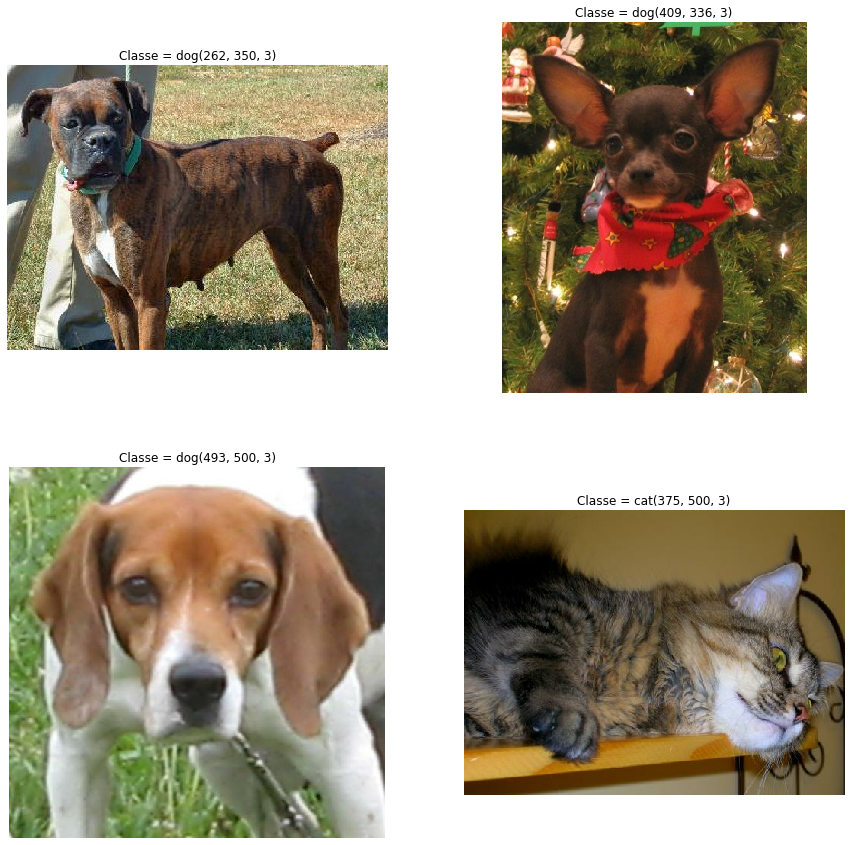

In [5]:

plt.figure(figsize=(15, 15))
for i, (image, label) in enumerate(raw_train.take(4)):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.title("Classe = "+str(get_label_name(label))  +str(image.shape))
    plt.axis("off")

On constate que les images n'ont pas les memes formes. On veux utiliser un réseau CNN pour la classification, par conséquent il faut que les images soient de même taille et centrées.
IMG_SIZE = 160 , Toutes les images seront redimensionnées en 160x160   

In [6]:
IMG_SIZE=160
def rezised(image,label):
    image = tf.cast(image, tf.float32)  
    image = (image/127.5) - 1  
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  
    return image, label


Appliquez cette fonction à chaque élément de l'ensemble de données en utilisant la méthode de **map**:

In [7]:
train = raw_train.map(rezised)
validation = raw_validation.map(rezised)
test = raw_test.map(rezised)

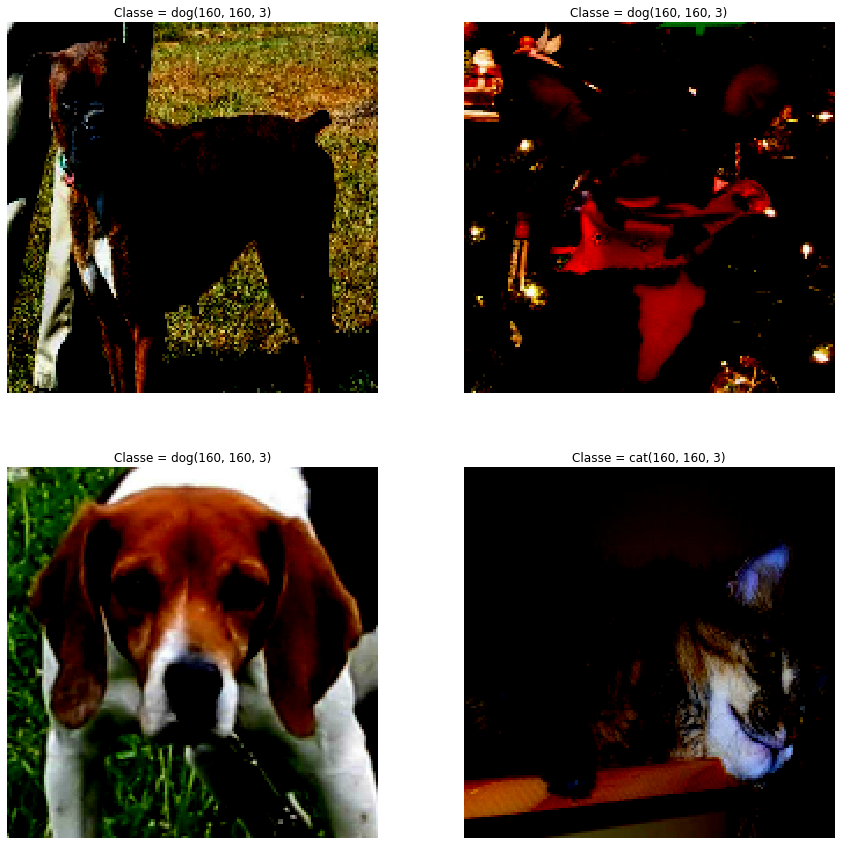

In [8]:

plt.figure(figsize=(15, 15))
for i, (image, label) in enumerate(train.take(4)):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.title("Classe = "+str(get_label_name(label))  +str(image.shape))
    plt.axis("off")

In [9]:
batch_size = 32
SHUFFLE_BUFFER_SIZE = 1000 #pour mélanger les données.

In [10]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
validation_batches = validation.batch(batch_size)
test_batches = test.batch(batch_size)

## Le modèle
 le modèle **MobileNet V2** a été déja entraîné sur 1,4 M d’images.

Nos images sont carrées et en couleur(s). On n’inclut pas la dernière couche (celle qui fait la classification) et on n’utilise les poids calculés sur le jeu de données ImageNet.
ImageNet est un ensemble de données de formation à la recherche avec une grande variété de catégories comme le jacquier et la seringue. Cette base de connaissances nous aidera à classer les chats et les chiens à partir de notre ensemble de données spécifique.

Tout d'abord, vous devez choisir la couche de MobileNet V2 que vous utiliserez pour l'extraction de caractéristiques. La toute dernière couche de classification. On charge un réseau qui n'inclut pas les couches de classification, ce qui est idéal pour l'extraction des caractéristiques.




In [11]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
# Création de modèle de base à partir du modèle pré-entrainé MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # on inclut pas la dernier couche dense
                                               weights='imagenet') # les variables poids calculées


In [12]:

base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

l'extracteur de features convertit chaque image 160x160x3 en un bloc de caractéristiques 5x5x1280.


In [13]:
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape

TensorShape([32, 160, 160, 3])

In [14]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


## Extraction de feature
Dans cette étape, on va geler la base convolutive créée à l'étape précédente et  utiliser comme extracteur de feature. En plus, on va ajouter un classificateur par-dessus et on entraîne le classificateur.

C'est vraiment important de geler **base_model** avant de compiler et l'apprentissage. Le fait de géler empêche la mise à jour des poids dans une couche donnée pendant l'entraînement car MobileNet V2 comporte de nombreuses couches.

In [15]:
base_model.trainable=False

Dans l'étape précédente avant de geler on avait **Trainable params= 2,223,872**. Apres le gele on maintenant **Trainable params=0**



In [16]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

## Ajout d'une couche de classification à la tete

Pour générer des prédictions à partir des bloc d'éléments, on utilise une couche **tf.keras.layers.GlobalAveragePooling2D** pour convertir les éléments en un seul vecteur de 1280 éléments par image.

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # couche de la moyenne globale
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Appliquer une couche Dense pour convertir ces éléments en une seule prédiction par image. On n'a pas besoin d'une fonction d'activation ici car cette prédiction sera traitée comme un logit. Les nombres positifs prédisent la classe 1, les nombres négatifs prédisent la classe 0.

In [18]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Maintenant, empilez l'extracteur de caractéristiques et ces deux couches en utilisant un modèle séquentiel tf.keras

In [19]:
model=tf.keras.Sequential([base_model,global_average_layer,prediction_layer])

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


environ 2,25 millions de paramètres de MobileNet sont gelés, mais il existe 1,2 K de paramètres entrainable dans la couche dense. Ils sont répartis entre deux objets variables (les poids et les biais)

In [22]:
len(model.trainable_variables)

2

#### Accuracy du nouveau modèle avant l'apprentissage

In [23]:
epoch_initial=10
validation_step=20

Loss,Accuracy=model.evaluate(validation_batches,steps=validation_step)
print(" Accuracy: {:5.2f}%".format(100*Accuracy))
print(" Loss: {:5.2f}%".format(100*Loss))

20/20 [==============================] - 13s 672ms/step - loss: 1.0611 - accuracy: 0.4719
 Accuracy: 47.19%
 Loss: 106.11%


## Apprentissage du nouveau modèle

In [25]:
Training=model.fit(train_batches,epochs=epoch_initial,validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 555s 953ms/step - loss: 0.0747 - accuracy: 0.9737 - val_loss: 0.0701 - val_accuracy: 0.9703
Epoch 2/10
582/582 [==============================] - 588s 1s/step - loss: 0.0589 - accuracy: 0.9781 - val_loss: 0.0607 - val_accuracy: 0.9759
Epoch 3/10
582/582 [==============================] - 620s 1s/step - loss: 0.0522 - accuracy: 0.9801 - val_loss: 0.0565 - val_accuracy: 0.9764
Epoch 4/10
582/582 [==============================] - 582s 1s/step - loss: 0.0487 - accuracy: 0.9812 - val_loss: 0.0536 - val_accuracy: 0.9776
Epoch 5/10
582/582 [==============================] - 575s 987ms/step - loss: 0.0463 - accuracy: 0.9828 - val_loss: 0.0517 - val_accuracy: 0.9794
Epoch 6/10
582/582 [==============================] - 543s 933ms/step - loss: 0.0445 - accuracy: 0.9831 - val_loss: 0.0504 - val_accuracy: 0.9798
Epoch 7/10
582/582 [==============================] - 547s 940ms/step - loss: 0.0430 - accuracy: 0.9838 - val_loss: 0.0494 - val_accu

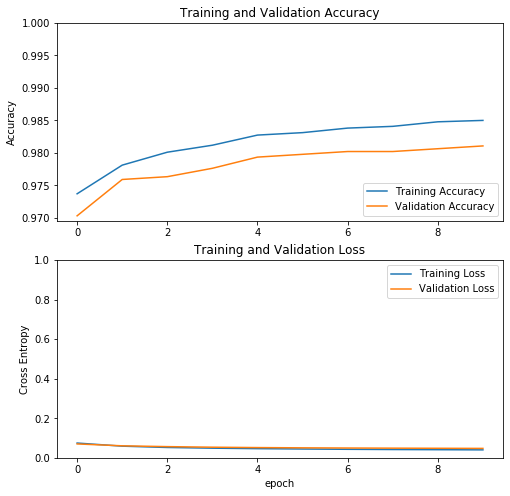

In [26]:


acc = Training.history['accuracy']
val_acc = Training.history['val_accuracy']

loss = Training.history['loss']
val_loss = Training.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Remarque : 
si on se demande pourquoi les mesures de validation sont nettement meilleures que les mesures d'entrainement, le facteur principal est que des couches comme **tf.keras.layers.BatchNormalization** et **tf.keras.layers.Dropout** affectent la précision pendant l'apprentissage. Elles sont désactivées lors du calcul de la perte de validation.

C'est aussi parce que les métriques de l'entrainement rapportent la moyenne pour une époque, alors que les métriques de validation sont évaluées après l'époque, de sorte que les métriques de validation voient un modèle qui s'est entraîné un peu plus longtemps.



Une façon d'augmenter encore les performances est d'entraîner (ou de "régler avec précision") les poids des couches supérieures du modèle préétabli en même temps que l'entraînement du classificateur que vous avez ajouté. Le processus de formation forcera les poids à être ajustés à partir de cartes de caractéristiques génériques vers des caractéristiques associées spécifiquement à l'ensemble de données.

Remarque : cette opération ne doit être tentée qu'après avoir formé le classificateur de niveau supérieur avec le modèle préformé réglé sur "non-traitable". Si vous ajoutez un classificateur initialisé aléatoirement au dessus d'un modèle préformé et que vous essayez d'entraîner toutes les couches conjointement, l'ampleur des mises à jour du gradient sera trop importante (en raison des poids aléatoires du classificateur) et votre modèle préformé oubliera ce qu'il a appris.

De plus, vous devriez essayer de régler un petit nombre de couches supérieures plutôt que l'ensemble du modèle MobileNet. Dans la plupart des réseaux convolutifs, plus une couche est élevée, plus elle est spécialisée. Les premières couches apprennent des caractéristiques très simples et génériques qui se généralisent à presque tous les types d'images. Plus on monte, plus les caractéristiques sont spécifiques à l'ensemble de données sur lequel le modèle a été formé. L'objectif du réglage fin est d'adapter ces caractéristiques spécialisées au nouvel ensemble de données, plutôt que d'écraser l'apprentissage générique.



### Degeler les couches du modèle
Tout ce qu'on veut est de dégeler le modèle de base et de régler les couches inférieures pour qu'elles ne puissent pas être entrainer. Ensuite, on va recompiler le modèle  et reprendre l'entraînement.

In [27]:
base_model.trainable = True

In [30]:
len(base_model.layers) # nombres de couche de notre modèle de base

155

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [33]:
len(model.trainable_variables)

158

### Amélioration du modèle :Continuer l'apprentissage


In [34]:
epoch_after=10
epoch_total=epoch_initial+epoch_after


In [37]:
history=model.fit(train_batches,
                  epochs=epoch_total,
                 initial_epoch =  Training.epoch[-1],

                  validation_data=validation_batches)

Epoch 10/20
582/582 [==============================] - 2020s 3s/step - loss: 0.1254 - accuracy: 0.9526 - val_loss: 0.0730 - val_accuracy: 0.9811
Epoch 11/20
582/582 [==============================] - 2061s 4s/step - loss: 0.0637 - accuracy: 0.9752 - val_loss: 0.0560 - val_accuracy: 0.9802
Epoch 12/20
582/582 [==============================] - 2072s 4s/step - loss: 0.0470 - accuracy: 0.9816 - val_loss: 0.0486 - val_accuracy: 0.9824
Epoch 13/20
582/582 [==============================] - 5923s 10s/step - loss: 0.0355 - accuracy: 0.9865 - val_loss: 0.0478 - val_accuracy: 0.9815
Epoch 14/20
582/582 [==============================] - 1978s 3s/step - loss: 0.0270 - accuracy: 0.9902 - val_loss: 0.0485 - val_accuracy: 0.9819
Epoch 15/20
582/582 [==============================] - 1945s 3s/step - loss: 0.0188 - accuracy: 0.9932 - val_loss: 0.0506 - val_accuracy: 0.9811
Epoch 16/20
582/582 [==============================] - 4674s 8s/step - loss: 0.0161 - accuracy: 0.9940 - val_loss: 0.0536 - val_a

In [39]:
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']

loss += history.history['loss']
val_loss += history.history['val_loss']

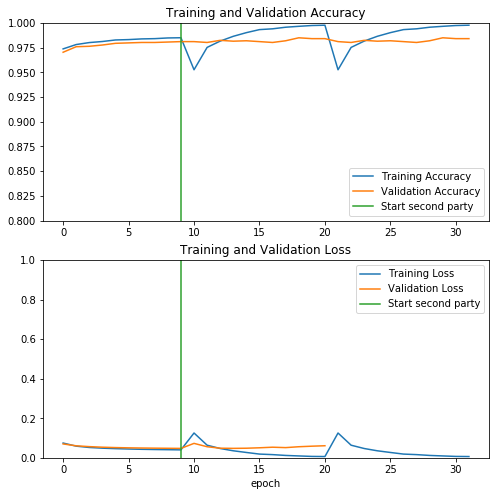

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epoch_initial-1,epoch_initial-1],
          plt.ylim(), label='Start second party')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epoch_initial-1,epoch_initial-1],
         plt.ylim(), label='Start second party')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

En examinant l'évolution des courbes, on constate loss de validation est beaucoup plus élevée que la loss du training, et il se peut donc que qu'on soit confronté à un problème d'overfiting. La précision sur la validation est environ $98.5\%$

## Conclusion

#### Utilisation d'un modèle pré-entrainé pour l'extraction de features :
Lorsque l'on travaille avec une petite base de données, il est important de tirer parti des caractéristiques apprises par un modèle pré-entrainé sur une base de données plus importante dans **le même domaine** c'est très important. Cela se fait en ajoutant  au modèle pré-entrainé un classifieur (FC) entièrement connecté. D'abord le modèle pré-entrainé est "gelé" et seuls les poids du classifieur sont mis à jour pendant l'entrainement. Cela permet d'extraire toutes les features associées à chaque image et on vient d'entrainer un classifieur qui détermine la classe de l'image en fonction de l'ensemble des caractéristiques extraites.

#### Mise au point d'un modèle préformé : 
Pour améliorer encore les performances, il est possible de réadapter les couches supérieures des modèles pré-entrainé au nouvel ensemble de données qui est la second entrainement (réglage). Dans ce cas, vous avez réglé vos poids de manière à ce que votre modèle apprenne les caractéristiques de haut niveau spécifiques à l'ensemble de données. Cette technique est généralement recommandée lorsque l'ensemble de données d'entraînement est important et très similaire à l'ensemble de données original sur lequel le modèle préétabli a été entraîné.

